In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
import pandas as pd

def load_and_filter_esg_data(file_path: str, year: str) -> pd.DataFrame:
    """
    Loads ESG data from a CSV file and filters it by year.

    Parameters:
    - file_path (str): Path to the ESG CSV file.
    - year (str or int): Year to filter the data.

    Returns:
    - pd.DataFrame: Filtered ESG DataFrame.
    """
    # Load CSV
    df = pd.read_csv(file_path, sep='|', encoding='utf-8')

    # Show columns to verify structure
    print("✅ Loaded columns:", df.columns.tolist())

    # Ensure 'year' column exists and filter by year
    if 'year' not in df.columns:
        raise ValueError("The 'year' column was not found in the dataset.")

    df = df[df['year'] == int(year)]

    # Keep only relevant columns
    filtered_df = df[['company_name', 'metric_name', 'metric_value_scaled']].copy()
    filtered_df = filtered_df[filtered_df['metric_value_scaled'].notnull()]

    print(f"✅ Filtered ESG data for year {year}. Rows:", filtered_df.shape[0])
    return filtered_df


In [3]:
def pivot_and_impute_esg_data(filtered_df: pd.DataFrame) -> pd.DataFrame:
    """
    Pivots the ESG data to create a company × metric matrix and imputes missing values
    with column-wise mean.

    Parameters:
    - filtered_df (pd.DataFrame): DataFrame with 'company_name', 'metric_name', and 'metric_value_scaled'.

    Returns:
    - pd.DataFrame: Clean pivoted matrix with no missing values.
    """
    # Pivot data to company × metric matrix
    pivot_df = filtered_df.pivot_table(index='company_name',
                                       columns='metric_name',
                                       values='metric_value_scaled',
                                       aggfunc='mean')

    # Impute missing values using column-wise mean
    pivot_df_clean = pivot_df.fillna(pivot_df.mean())

    # Optional: Show the resulting shape
    print(" Pivoted ESG matrix shape:", pivot_df_clean.shape)

    return pivot_df_clean


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

def perform_pca_on_esg_data(pivot_df_clean: pd.DataFrame, n_components: int = 2):
    """
    Standardizes ESG data and applies PCA.

    Parameters:
    - pivot_df_clean (pd.DataFrame): Cleaned company × metric ESG matrix.
    - n_components (int): Number of PCA components (default=2).

    Returns:
    - pca_model: fitted PCA model
    - pca_df: DataFrame with PCA components
    - scaled_data: standardized ESG data
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pivot_df_clean)

    # Apply PCA
    pca_model = PCA(n_components=n_components)
    pca_components = pca_model.fit_transform(scaled_data)

    # Store PCA components in DataFrame
    pca_df = pd.DataFrame(pca_components,
                          columns=[f'PC{i+1}' for i in range(n_components)],
                          index=pivot_df_clean.index)
    pca_df.reset_index(inplace=True)

    print("✅ PCA applied. PCA DataFrame shape:", pca_df.shape)
    return pca_model, pca_df, scaled_data


In [5]:
import pandas as pd
from sklearn.decomposition import PCA

def analyze_pca_loadings(pca_model: PCA, pivot_df_clean: pd.DataFrame, top_n: int = 10) -> tuple:
    """
    Analyzes PCA loadings to identify the top contributing ESG metrics to PC1 and PC2.

    Parameters:
    - pca_model (PCA): Fitted PCA object.
    - pivot_df_clean (pd.DataFrame): DataFrame used to fit PCA (for column names).
    - top_n (int): Number of top metrics to return for each component.

    Returns:
    - loadings_df (pd.DataFrame): Loadings DataFrame with absolute values.
    - top_pc1 (pd.DataFrame): Top N metrics contributing to PC1.
    - top_pc2 (pd.DataFrame): Top N metrics contributing to PC2.
    """
    loadings = pca_model.components_.T

    loadings_df = pd.DataFrame(loadings,
                               index=pivot_df_clean.columns,
                               columns=[f'PC{i+1}' for i in range(pca_model.n_components_)])

    # Add absolute values for sorting
    for pc in loadings_df.columns:
        loadings_df[f'{pc}_abs'] = loadings_df[pc].abs()

    # Extract top contributors
    top_pc1 = loadings_df.sort_values(by='PC1_abs', ascending=False)[['PC1']].head(top_n)
    top_pc2 = loadings_df.sort_values(by='PC2_abs', ascending=False)[['PC2']].head(top_n)

    # Print for reference
    print("🔍 Top", top_n, "Metrics Contributing to PC1:")
    print(top_pc1)
    print("\n🔍 Top", top_n, "Metrics Contributing to PC2:")
    print(top_pc2)

    return loadings_df, top_pc1, top_pc2


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_metric_heatmap(top_pc1: pd.DataFrame,
                            top_pc2: pd.DataFrame,
                            loadings_df: pd.DataFrame,
                            title: str = "🔍 Top ESG Metric Contributions to PC1 and PC2") -> None:
    """
    Plots a heatmap of PCA loadings for top contributing metrics to PC1 and PC2.

    Parameters:
    - top_pc1 (pd.DataFrame): DataFrame of top PC1 metrics with loading values.
    - top_pc2 (pd.DataFrame): DataFrame of top PC2 metrics with loading values.
    - loadings_df (pd.DataFrame): Full PCA loadings DataFrame.
    - title (str): Plot title.
    """

    # Combine metric names
    top_metrics = pd.concat([top_pc1, top_pc2])
    top_metrics = top_metrics[~top_metrics.index.duplicated()]

    # Slice relevant loadings
    heatmap_data = loadings_df.loc[top_metrics.index, ['PC1', 'PC2']]

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0,
                cbar_kws={'label': 'PCA Loading'})
    plt.title(title)
    plt.xlabel("Principal Components")
    plt.ylabel("ESG Metrics")
    plt.tight_layout()
    plt.show()


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_pca_scatter(pca_df: pd.DataFrame,
                     x_col: str = 'PC1',
                     y_col: str = 'PC2',
                     title: str = "🏢 PCA Scatter Plot of Companies Based on ESG Profiles",
                     color: str = 'steelblue') -> None:
    """
    Plots a scatter plot of companies based on their PCA component scores.

    Parameters:
    - pca_df (pd.DataFrame): DataFrame containing PCA results with PC1, PC2 and index (company).
    - x_col (str): Column name for X-axis (default: 'PC1').
    - y_col (str): Column name for Y-axis (default: 'PC2').
    - title (str): Plot title.
    - color (str): Dot color.
    """

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pca_df, x=x_col, y=y_col, color=color, s=70)

    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_pca_biplot_top2_features(pca_df: pd.DataFrame,
                                  loadings_df: pd.DataFrame,
                                  scale: float = 8,
                                  arrow_colors: list = ['darkred', 'darkgreen'],
                                  title: str = "📍 Clean PCA Biplot: Top ESG Metric Drivers") -> None:
    """
    Plots a PCA biplot with the top contributing features for PC1 and PC2 as arrows.

    Parameters:
    - pca_df (pd.DataFrame): DataFrame containing PC1 and PC2 columns for each company.
    - loadings_df (pd.DataFrame): PCA loadings DataFrame with columns ['PC1', 'PC2', 'PC1_abs', 'PC2_abs'].
    - scale (float): Scaling factor for arrow length.
    - arrow_colors (list): List of two colors for the PC1 and PC2 arrows.
    - title (str): Plot title.
    """
    # Identify top features
    top_pc1_feature = loadings_df['PC1_abs'].idxmax()
    top_pc2_feature = loadings_df['PC2_abs'].idxmax()
    selected_features = [top_pc1_feature, top_pc2_feature]

    # Set up plot
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Scatter plot of companies
    ax.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, color='skyblue', s=50)

    # Draw arrows and labels
    for i, feature in enumerate(selected_features):
        x = loadings_df.loc[feature, 'PC1'] * scale
        y = loadings_df.loc[feature, 'PC2'] * scale

        ax.arrow(0, 0, x, y, color=arrow_colors[i], linewidth=2.5,
                 head_width=0.5, head_length=0.7, length_includes_head=True, alpha=0.8)

        ax.text(x * 1.15, y * 1.15, feature,
                fontsize=14, color=arrow_colors[i], fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9))

    # Final plot formatting
    ax.set_xlabel("Principal Component 1", fontsize=12)
    ax.set_ylabel("Principal Component 2", fontsize=12)
    ax.set_title(title, fontsize=15)
    ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='grey', linewidth=0.5, linestyle='--')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def plot_scree_plot(scaled_data: np.ndarray,
                    title: str = '📈 Scree Plot: Explained Variance by PCA Components') -> None:
    """
    Generates a scree plot showing the explained variance by each principal component.

    Parameters:
    - scaled_data (np.ndarray): Standardized ESG feature matrix.
    - title (str): Custom title for the plot.
    """

    # Fit PCA with all components
    pca_full = PCA()
    pca_full.fit(scaled_data)

    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Create the scree plot
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance,
            alpha=0.5, align='center', label='Individual Explained Variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance,
             where='mid', label='Cumulative Explained Variance', color='red')

    plt.xlabel('Principal Component Index')
    plt.ylabel('Explained Variance Ratio')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
def run_pca_pipeline(file_path: str, year: str):
    """
    Orchestrates the traditional PCA analysis pipeline on ESG data.

    Parameters:
    - file_path: str: Path to the ESG CSV data file.
    - year: str: Year to filter data on.
    """
    # Load and filter data
    filtered_df = load_and_filter_esg_data(file_path, year)

    # Create pivot table
    pivot_df_clean = pivot_and_impute_esg_data(filtered_df)

    # Apply PCA
    pca_model, pca_df, scaled_data = perform_pca_on_esg_data(pivot_df_clean)

    # Step 4: Extract loadings and top metrics
    loadings_df, top_pc1, top_pc2 = analyze_pca_loadings(pca_model, pivot_df_clean)

    # Plot heatmap of contributions
    plot_top_metric_heatmap(top_pc1, top_pc2, loadings_df)

    # Scatter plot of companies in PCA space
    plot_pca_scatter(pca_df)

    # Clean biplot with 2 dominant metrics
    plot_pca_biplot_top2_features(pca_df, loadings_df)

    # Scree plot for explained variance
    plot_scree_plot(scaled_data)

    print("✅ PCA analysis pipeline completed successfully.")


✅ Loaded columns: ['company_name', 'perm_id', 'data_type', 'disclosure', 'metric_description', 'metric_name', 'metric_unit', 'metric_value', 'nb_points_of_observations', 'pillar', 'Industry', 'year', 'metric_value_scaled', 'metric_value_log']
✅ Filtered ESG data for year 2022. Rows: 44007
 Pivoted ESG matrix shape: (2911, 82)
✅ PCA applied. PCA DataFrame shape: (2911, 3)
🔍 Top 10 Metrics Contributing to PC1:
                                    PC1
metric_name                            
TARGETS_EMISSIONS              0.231416
POLICY_FREEDOMOF_ASSOCIATION   0.229095
TOXIC_CHEMICALS_REDUCTION      0.228376
SUSTAINABLE_BUILDING_PRODUCTS  0.219252
POLICY_HUMAN_RIGHTS            0.204541
GLOBAL_COMPACT                 0.199095
SOXEMISSIONS                   0.195608
VOCEMISSIONS                   0.192624
NOXEMISSIONS                   0.179412
POLICY_FORCED_LABOR            0.176648

🔍 Top 10 Metrics Contributing to PC2:
                                    PC2
metric_name                  

/var/folders/v3/n64gn7dn3xvb1j8vfzyfdrq00000gn/T/ipykernel_44988/2344663383.py:33: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/Jords/Desktop/capstone-project-2025-t1-25t1-9900-t12a-chocolate/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


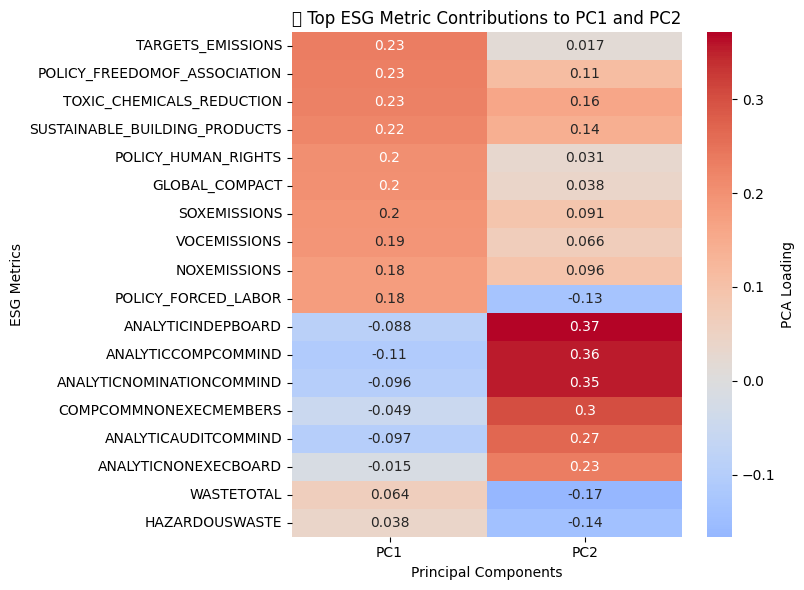

/var/folders/v3/n64gn7dn3xvb1j8vfzyfdrq00000gn/T/ipykernel_44988/600738807.py:28: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/Jords/Desktop/capstone-project-2025-t1-25t1-9900-t12a-chocolate/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


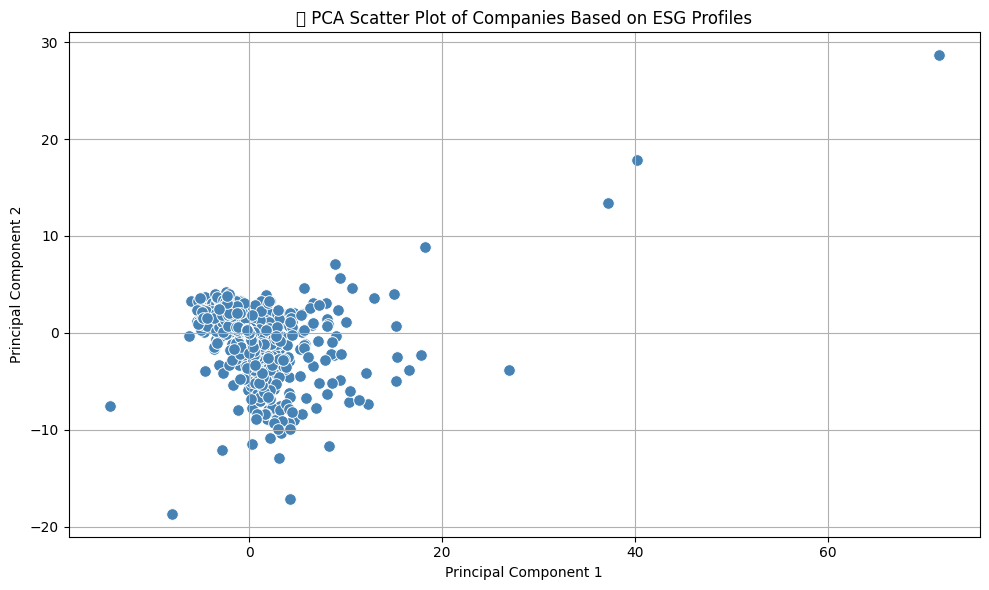

/var/folders/v3/n64gn7dn3xvb1j8vfzyfdrq00000gn/T/ipykernel_44988/1084366150.py:52: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/Jords/Desktop/capstone-project-2025-t1-25t1-9900-t12a-chocolate/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


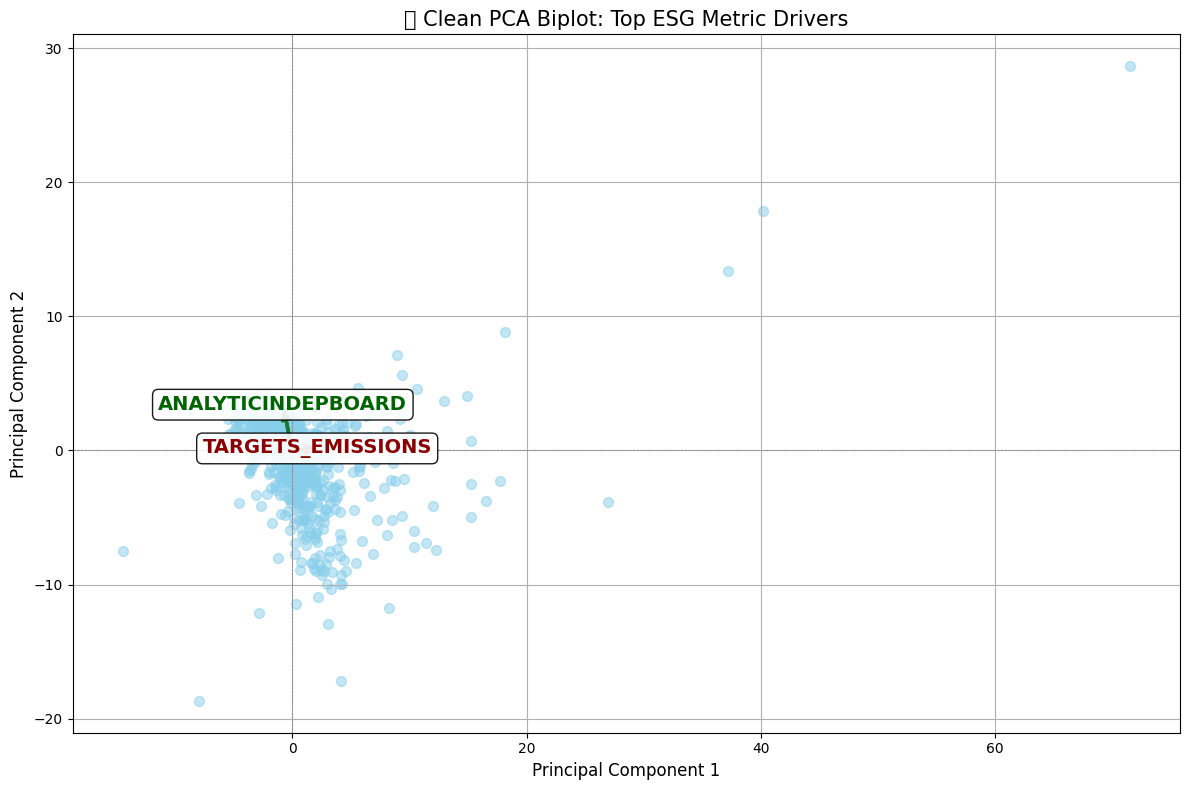

/var/folders/v3/n64gn7dn3xvb1j8vfzyfdrq00000gn/T/ipykernel_44988/153130263.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/Jords/Desktop/capstone-project-2025-t1-25t1-9900-t12a-chocolate/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


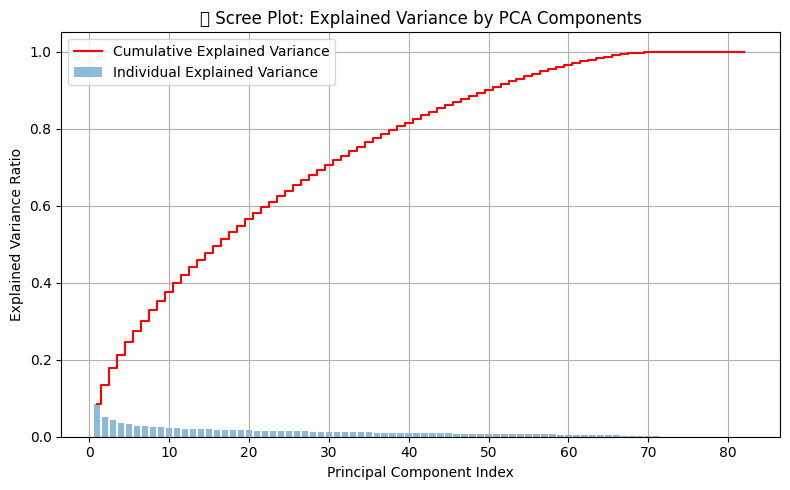

✅ PCA analysis pipeline completed successfully.


In [ ]:
run_pca_pipeline("../Normalized_Data/semiconductors_esg_consolidated.csv", year="2022")
#run_pca_pipeline("../Normalized_Data/biotechnology_and_pharmaceuticals_esg_consolidated.csv", year="2022")